In [45]:
%reload_ext autoreload
%autoreload 2

In [46]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [47]:
from dataset import HelocDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [48]:
from dataset import dataset_loader

In [49]:
name = 'heloc'
dataset_ares = dataset_loader(name, data_path='data/', dropped_features=[], n_bins=None)

In [50]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

In [51]:
dataset = HelocDataset(dataset_ares=dataset_ares)

input_dim = dataset.get_dataframe().shape[1] - 1
seed = None
# torch.manual_seed(seed)

counterfactual_algorithms = [
    # 'DiCE',
    # 'DisCount',
    'GlobeCE',
    'AReS',
    # 'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        "CF_OTMatch",
        "CF_OTMatch_2.0", 
        # "CF_OTMatch_50.0",
        # "CF_OTMatch_100.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 300
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")

INFO:root:PyTorchDNN accuracy: 0.7210126582278481
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchDNN counterfactuals with GlobeCE
100%|██████████| 300/300 [00:00<00:00, 2420.57it/s]
INFO:root:Computing PyTorchDNN counterfactuals with AReS


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 8034 combinations | Sampling itemset size 65
SD and RL Computed with Lengths 1665 and 1665
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 1665 to 160


100%|██████████| 1665/1665 [00:04<00:00, 343.17it/s]


Ground Set Computed with Length 134218


199it [00:00, 754.39it/s]


Candidate Set Filtered with Length: 200
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 199/199 [00:00<00:00, 10822.40it/s]


Checking Exchange


100%|██████████| 199/199 [00:00<00:00, 21750.27it/s]
0it [00:00, ?it/s]


In [52]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_intervention_policies(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by GlobeCE


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:root:Shapley values for PyTorchDNN using CF_SingleMatch with counterfactual by GlobeCE
INFO:root:Shapley values for PyTorchDNN using CF_OTMatch with counterfactual by GlobeCE
INFO:root:Shapley values for PyTorchDNN using CF_OTMatch_2.0 with counterfactual by GlobeCE
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by AReS


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Shapley values for PyTorchDNN using CF_SingleMatch with counterfactual by AReS
INFO:root:Shapley values for PyTorchDNN using CF_OTMatch with counterfactual by AReS
INFO:root:Shapley values for PyTorchDNN using CF_OTMatch_2.0 with counterfactual by AReS


In [43]:
experiment.md_baseline = False

In [44]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 200, 400, 600, 1000, 1500, 1600, 1700, 1800, 2000, 2100, 2200, 2300, 2500, 3000, 3500, 4000],
    trials_num=10,
    replace=False,
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Policy for PyTorchDNN using CF_UniformMatch with counterfactual by GlobeCE
INFO:root:Computing optimal_transport for (PyTorchDNN, GlobeCE, CF_UniformMatch)
  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

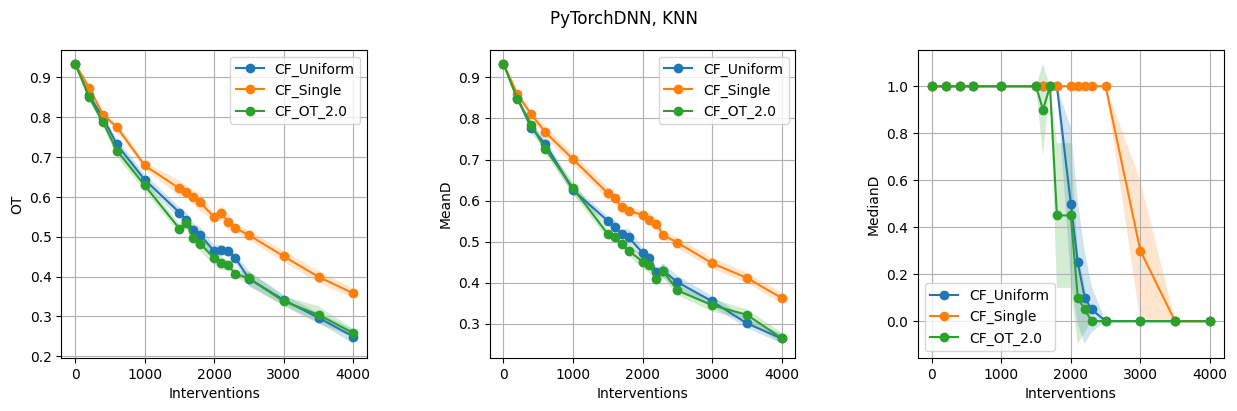

In [ ]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)